In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
try:
    from torchvision import transforms, utils
except:
    !conda install --yes torchvision --no-channel-priority
    from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
try:
    from torchvision import transforms, utils
except:
    !pip install torchvision
    from torchvision import transforms, utils
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# You want to change these to be your own filenames
csv_file = 'flood_sample_metadata.csv'
label_csv = 'flood_sample_label.csv'

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [3]:
# read the tsv file with the labels
ladi_responses = pd.read_csv("http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_aggregated_responses_url.tsv",delimiter='\t',header='infer')
ladi_responses.head(1000)

,url,WorkerId,Answer
0,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,['damage:flood/water']
1,https://ladi.s3-us-west-2.amazonaws.com/Images...,1,['damage:flood/water']
2,https://ladi.s3-us-west-2.amazonaws.com/Images...,2,['damage:flood/water']
3,https://ladi.s3-us-west-2.amazonaws.com/Images...,20,['damage:flood/water']
4,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,['damage:flood/water']
5,https://ladi.s3-us-west-2.amazonaws.com/Images...,8,"['damage:flood/water', 'damage:washout']"
6,https://ladi.s3-us-west-2.amazonaws.com/Images...,9,"['damage:rubble', 'damage:flood/water']"
7,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,['damage:rubble']
8,https://ladi.s3-us-west-2.amazonaws.com/Images...,1,['damage:none']
9,https://ladi.s3-us-west-2.amazonaws.com/Images...,11,['damage:flood/water']


In [4]:
# Strip off bracket and comma from the Answer catagory
ladi_responses["Answer"] = ladi_responses["Answer"].str.strip('[|]')
# split list of responses into multiple rows
ladi_responses["Answer"] = ladi_responses["Answer"].str.split(",",expand = True)
# remove the single quote character from either end of string
ladi_responses["Answer"] = ladi_responses["Answer"].str.strip('\'')
# add a column to help with aggregation when pivoting
ladi_responses["response_count"] = 1
# Create a matrix with the number of workers who answered given label for given image
# using pivot table; filling in nan values with 0
label_matrix = ladi_responses.pivot_table(values='response_count', 
                                          index='url', 
                                          columns='Answer', 
                                          aggfunc='sum',
                                          fill_value=0)
label_matrix

Answer,damage:flood/water,damage:landslide,damage:misc,damage:none,damage:rubble,damage:smoke/fire,damage:washout,environment:dirt,environment:grass,environment:lava,environment:none,environment:rock,environment:sand,environment:shrubs,environment:snow/ice,environment:trees,infrastructure:bridge,infrastructure:building,infrastructure:communications-tower,infrastructure:dam-levee,infrastructure:none,infrastructure:pipe,infrastructure:railway,infrastructure:road,infrastructure:utility-line,infrastructure:water-tower,vehicle:aircraft,vehicle:boat,vehicle:car,vehicle:none,vehicle:truck,water:flooding,water:lake,water:none,water:ocean,water:puddle,water:river
url,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0020_e34a1edc-6d5c-472e-847e-89dac3ed4519.jpg,2,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0028_18dcd0d8-4b79-452e-9ade-604d4f13ddfd.jpg,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0035_add5632e-eec2-42a4-a7db-8c42871164c2.jpg,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0042_970b36fb-582b-4b51-a581-923efb394278.jpg,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20147/DSC_1575_787dc8f2-fb8f-4464-99a2-45ba5fc677c2.jpg,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3990_bdd98b00-d138-4daa-b842-4a4266cb2de9.jpg,0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3997_d3d2337b-b3e3-468c-8e2c-93ba34f9a219.jpg,1,0,1,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_4000_af3e8e76-fbba-4a6f-8aa7-44cd7c35fdaf.jpg,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# damage_matrix[damage_matrix['damage:washout'] > 0].shape[0]

# floodwater: 14K
# landslide: 800, remove
# misc: remove
# none: 34K
# rubble: 4K
# smoke/fire: 1.2K
# washout: 674, remove


In [5]:
# if none is greater than each of the other labels, keep none
# else, drop none

# if anything at end is > 0, that is a label.
labels = ['damage:flood/water', 'damage:rubble', 'damage:smoke/fire']
def proc(row):
    
    
    arr = [row[x] for x in labels]
    if row['damage:none'] > max(arr):
        for x in labels:
            row[x] = 0
        row['damage:none'] = 1
    else:
        row['damage:none'] = 0
        
        for x in labels:
            if row[x] > 0: row[x] = 1
            
    return row
        
    

damage_matrix = label_matrix[labels + ['damage:none']]
final_mat = damage_matrix.apply(proc, axis = 1)

In [7]:
final_mat

Answer,damage:flood/water,damage:rubble,damage:smoke/fire,damage:none
url,,,,
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0020_e34a1edc-6d5c-472e-847e-89dac3ed4519.jpg,0,0,0,1
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0028_18dcd0d8-4b79-452e-9ade-604d4f13ddfd.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0035_add5632e-eec2-42a4-a7db-8c42871164c2.jpg,0,0,0,1
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0042_970b36fb-582b-4b51-a581-923efb394278.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20147/DSC_1575_787dc8f2-fb8f-4464-99a2-45ba5fc677c2.jpg,1,0,0,0
...,...,...,...,...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3990_bdd98b00-d138-4daa-b842-4a4266cb2de9.jpg,0,0,0,1
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3997_d3d2337b-b3e3-468c-8e2c-93ba34f9a219.jpg,0,0,0,1
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_4000_af3e8e76-fbba-4a6f-8aa7-44cd7c35fdaf.jpg,0,0,0,1


In [6]:
# Load ladi_images_metadata.csv
metadata = pd.read_csv('http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_images_metadata.csv')

In [7]:
sample_size=500
# none_sample = final_mat[final_mat['damage:none'] == 1].sample(sample_size)
# none_sample.shape

samples = final_mat[final_mat['damage:flood/water'] == 1].sample(sample_size)
for col in final_mat.columns[1:]:
#     print(col)
#     print(final_mat[final_mat[col] == 1].shape)
#     print(final_mat[final_mat[col] == 1].sample(sample_size))
    samples = samples.append(final_mat[final_mat[col] == 1].sample(sample_size))
#     print(samples)
samples = samples.reset_index().drop_duplicates(subset='url', keep='first').set_index('url')
# df = pd.DataFrame()
# for i, s in enumerate(samples):
#     df = df.merge(s, how='outer', left_index=True, right_index=True)
samples.shape

(1961, 4)

In [8]:
samples.head(500)

Answer,damage:flood/water,damage:rubble,damage:smoke/fire,damage:none
url,,,,
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9073/613942/DSC_2140_6dae1a95-02a4-40a7-84de-26c0798af048.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9074/613722/DSC_0228_06c74dc2-d3a5-47e0-96b2-0ad19903fbc1.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9073/613941/DSC_4482_90530c28-5e2f-47b8-baeb-073de953e51f.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/3045/291508/DSC_1936_a2cb038c-dea1-46d7-861d-68b7084d3a39.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9073/613555/DSC_0933_23940b9d-a474-4ec5-a35f-bc6bc6596763.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9096/615126/SteveBla_4c32c8fa-6146-4e20-8eb1-6789d44c7009.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/3043/291559/CAP_3590_e92b1388-eb7a-42d4-a9c1-7f82e04b2bef.jpg,1,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9073/613586/DSC_1299_b16652ac-fa70-47cc-9314-f911d115a4e2.jpg,1,1,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9096/615127/TimCooli_ae076c6b-e383-452e-adbd-97b3d55a77f9.jpg,1,0,0,0


In [6]:
metadata_csv = 'damage_sample_metadata.csv'
label_csv = 'damage_sample_label.csv'

In [30]:
# Load ladi_images_metadata.csv
metadata = pd.read_csv('http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_images_metadata.csv')

# sampling
# sample_size=1000
# flood_sample = flood_examples.sample(sample_size)
# non_flood_sample = non_flood_examples.sample(sample_size)

# creating a df with True/False labels for flooding
# training_flood = pd.DataFrame(index=flood_sample.index, data={'label':True}).reset_index()
# training_non_flood = pd.DataFrame(index=non_flood_sample.index, data={'label':False}).reset_index()
# label_df = pd.concat([training_flood, training_non_flood], ignore_index=True)

samples.to_csv(label_csv)

# create list of urls to download
samples.reset_index()['url'].to_csv('urls_to_download.csv', index=False, header=False)

# # Get flood and non-flood metadata
damage_metadata = metadata[metadata['url'].isin(samples.index)]
# flood_metadata = metadata[metadata['url'].isin(flood_sample.index)]
# not_flood_metadata = metadata[metadata['url'].isin(non_flood_sample.index)]
# training_metadata = pd.concat([flood_metadata, not_flood_metadata], ignore_index=True)

damage_metadata.to_csv(metadata_csv)

In [ ]:
!mkdir -p training_images
!wget --content-disposition --trust-server-names -i urls_to_download.csv -P training_images/

DSC_8229_049e4a1e-d 100%[===================>]  13.82M  31.7MB/s    in 0.4s    

2021-07-30 04:25:28 (31.7 MB/s) - ‘training_images/DSC_8229_049e4a1e-dd75-4854-991d-4c5a80b98617.jpg’ saved [14496352/14496352]

--2021-07-30 04:25:28--  https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9073/613586/DSC_1255_f413ce67-5553-45de-9e48-d77f2b8323a8.jpg
Reusing existing connection to ladi.s3-us-west-2.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 10283347 (9.8M) [image/jpeg]
Saving to: ‘training_images/DSC_1255_f413ce67-5553-45de-9e48-d77f2b8323a8.jpg’

DSC_1255_f413ce67-5 100%[===================>]   9.81M  20.5MB/s    in 0.5s    

2021-07-30 04:25:29 (20.5 MB/s) - ‘training_images/DSC_1255_f413ce67-5553-45de-9e48-d77f2b8323a8.jpg’ saved [10283347/10283347]

--2021-07-30 04:25:29--  https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9073/613551/DSC_0615_733648a6-8006-4a4a-ac2a-a0bec8af4a69.jpg
Reusing existing connection to ladi.s3-us-west-2.amazonaws.com

In [7]:
scale = transforms.Resize(768)
crop = transforms.RandomCrop(512)
rotate = transforms.RandomRotation(20)
flip_demo = transforms.RandomHorizontalFlip(1) # flip with 100% chance just to demo
flip = transforms.RandomHorizontalFlip(p=0.5)
composed = transforms.Compose([scale,
                               crop,
                               rotate,
                               flip_demo])

In [8]:
# convenient function for showing the images
def show_image(image):
    plt.imshow(image)
    # pause a bit so that plots are updated
    plt.pause(0.01)

def convert_url_to_local_path(url):
    '''
    gets the location of the downloaded image
    '''
    return 'training_images/'+url.split('/')[-1]

class DamageSampleDataset(Dataset):

    def __init__(self, metadata_csv, label_csv, transform = None):
        """
        Args:
            metadata_csv (string): Path to the csv file with metadata.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.damage_sample_metadata = pd.read_csv(metadata_csv)
        # get the path in the shared directory
        self.damage_sample_metadata['local_path'] = self.damage_sample_metadata['url'].apply(convert_url_to_local_path)
        self.damage_sample_label = pd.read_csv(label_csv)
        self.damage_sample_data = pd.merge(self.damage_sample_metadata, 
                                        self.damage_sample_label,
                                       on="url")
        self.transform = transform
        
    def __len__(self):
        return len(self.damage_sample_metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## Load images from local directory. There is no need to redownload images to local machine. ##
        local_path = self.damage_sample_metadata.iloc[idx]['local_path']
        url = self.damage_sample_metadata.iloc[idx]['url']
        try:
            image = Image.fromarray(io.imread(local_path))
            img_name = local_path
        except:
            image = Image.fromarray(io.imread(url))
            img_name = url
        uuid = self.damage_sample_data.iloc[idx, 1]
        timestamp = self.damage_sample_data.iloc[idx, 2]
        gps_lat = self.damage_sample_data.iloc[idx, 3]
        gps_lon = self.damage_sample_data.iloc[idx, 4]
        gps_alt = self.damage_sample_data.iloc[idx, 5]
        file_size = self.damage_sample_data.iloc[idx, 6]
        width = self.damage_sample_data.iloc[idx, 7]
        height = self.damage_sample_data.iloc[idx, 8]
        label = torch.tensor(self.damage_sample_data.iloc[idx, -4:].tolist(), dtype=torch.float)
        
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 
                  'image_name': img_name, 
                  'damage_labels': label, 
                  'uuid': uuid, 
                  'timestamp': timestamp, 
                  'gps_lat': gps_lat, 
                  'gps_lon': gps_lon, 
                  'gps_alt': gps_alt, 
                  'orig_file_size': file_size, 
                  'orig_width': width, 
                  'orig_height': height}

        return sample
    def __str__(self):
        return self.damage_sample_data.to_string()
    
    def dataset(self):
        return self.damage_sample_data
    def dataset_type(self):
        return type(self.damage_sample_data)
    def get_columns(self):
        return self.damage_sample_data.columns

In [84]:
# damage_sample_dataset = DamageSampleDataset(metadata_csv = metadata_csv, label_csv = label_csv, transform = transforms.ToTensor())

In [9]:
transformed_dataset = DamageSampleDataset(metadata_csv = metadata_csv, 
                                       label_csv = label_csv, 
                                       transform = transforms.Compose([scale, 
                                                                       crop, 
#                                                                        rotate, 
#                                                                        flip, 
                                                                       transforms.ToTensor()]
                                                                     )
                                      )

In [11]:
# dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

batch_size = 16
test_split_ratio = .1
shuffle_dataset = True
random_seed = 42
# num_workers = 1

# Creating data indices for training and validation splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split_ratio * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                                sampler=test_sampler)

In [88]:
damage_sample_dataset[0]['image'].shape

torch.Size([3, 2000, 2992])

In [91]:
transformed_dataset[345]['image'].shape

torch.Size([3, 512, 512])

In [56]:
transformed_dataset[0]['image'].min()

tensor(0.)

In [54]:
len(train_indices)

1775

In [29]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
for i, data in enumerate(train_loader, 0):

ValueError: too many values to unpack (expected 2)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
try:
    from cnn_finetune import make_model
except:
    !pip install cnn-finetune
    from cnn_finetune import make_model

In [ ]:
def make_classifier(in_features, num_classes):
    return nn.Sequential(
        nn.Linear(in_features, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )

In [12]:
net = make_model('resnet18', num_classes=4, pretrained=True).cuda()

In [50]:
print(net)

ResNetWrapper(
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [13]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
t = torch.tensor([[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1]])

In [86]:
t

tensor([[0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]])

In [ ]:
def get_checkpoint_path(epoch):
    return f'epoch_checkpoints/checkpoint_epoch{epoch}.pth'

torch.backends.cudnn.benchmark = True # flag for some GPU optimizations
starting_epoch = 1
additional_epochs = 5
if starting_epoch > 1:
    net.load_state_dict(torch.load(get_checkpoint_path(starting_epoch)))
for epoch in range(starting_epoch, starting_epoch+additional_epochs):  # loop over the dataset multiple times
    running_loss, running_acc = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
#         net.train()
        # get the inputs; data is a list of [inputs, labels]
#         print(data['image'].shape)
#         print(data['damage_labels'])
#         print(data['damage_labels'].shape)
        inputs = data['image'].cuda()
        labels = data['damage_labels'].float().cuda()
        
        # casting int to long for loss calculation#
#         labels = labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
#         outputs = torch.sigmoid(net(inputs))
        outputs = net(inputs)
        print(torch.sigmoid(outputs))
#         outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        pred = (outputs > 0.5).float()
        correct = (pred == labels).all(1).float().sum()
        running_acc += correct
        if (i+1) % 10 == 0:    # print every 10 mini-batches
#             print(f'[epoch {epoch}, batch {i +1}] average loss: {running_loss/10}')
#             running_loss = 0.0         
            print(f'[Epoch {epoch}/{additional_epochs}, Batch {i+1}]    Loss: {running_loss/10}    Accuracy: {correct/(len(labels)*10)}')
            running_loss, running_acc = 0.0, 0.0
    # save the model
    PATH = get_checkpoint_path(epoch)
    torch.save(net.state_dict(), PATH)
print('Finished Training')

tensor([[0.5118, 0.5410, 0.5205, 0.5847],
        [0.5200, 0.4711, 0.4678, 0.5365],
        [0.6654, 0.5290, 0.4506, 0.5971],
        [0.4733, 0.5092, 0.5048, 0.8650],
        [0.6848, 0.6574, 0.4902, 0.6865],
        [0.5966, 0.6118, 0.6003, 0.6215],
        [0.5504, 0.5788, 0.5345, 0.6058],
        [0.6627, 0.4149, 0.5053, 0.4970],
        [0.5861, 0.6333, 0.4745, 0.6388],
        [0.7409, 0.5309, 0.5746, 0.6606],
        [0.4974, 0.5844, 0.5352, 0.6487],
        [0.3798, 0.5586, 0.6551, 0.6590],
        [0.6059, 0.4445, 0.4546, 0.6335],
        [0.5272, 0.5264, 0.5894, 0.7302],
        [0.4604, 0.4513, 0.5588, 0.6739],
        [0.4794, 0.5868, 0.4536, 0.7064]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[0.6590, 0.2679, 0.1970, 0.6243],
        [0.6059, 0.3125, 0.2339, 0.4851],
        [0.3248, 0.2319, 0.3652, 0.7484],
        [0.6786, 0.3853, 0.1889, 0.2514],
        [0.1262, 0.3601, 0.1137, 0.8790],
        [0.3253, 0.7693, 0.6135, 0.2322],
        [0.5512, 0.5094,

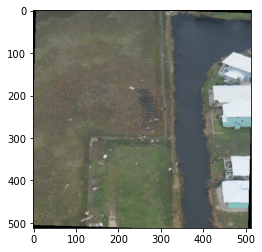

In [64]:
fig, ax = plt.subplots(1)
plt.imshow(data['image'][0].permute(1, 2, 0))

In [66]:
torch.set_printoptions(edgeitems=100)
print(data['image'][0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3765,
          0.3843, 0.3804, 0.3647, 0.3451, 0.3216, 0.3098, 0.2941, 0.2902,
          0.3098, 0.3216, 0.3059, 0.2980, 0.3059, 0.3098, 0.3098, 0.2980,
          0.2980, 0.3216, 0.3098, 0.3137, 0.3098, 0.3059, 0.3059, 0.3020,
          0.3137, 0.3137, 0.2941, 0.2863, 0.2784, 0.2784, 0.2706, 0.2902,
          0.3020, 0.3059, 0.3294, 0.3294, 0.3255, 0.3333, 0.3451, 0.3412,
          0.3412, 0.3333, 0.3294, 0.3333, 0.3451, 0.3451, 0.3373, 0.3412,
          0.3333, 0.3255, 0.3137, 0.3020, 0.3098, 0.3098, 0.2941, 0.3020,
          0.3020, 0.3216, 0.3255, 0.3216, 0.3098, 0.3098, 0.3137, 0.3059,
          0.3137, 0.3059, 0.3059, 0.3059, 0.3059, 0.3098, 0.2941, 0.3059,
          0.3216, 0.3176, 0.2941, 0.3059, 0.2941, 0.2863, 0.3176, 0.2980,
          0.2941, 0.2980, 0.3255, 0.3608, 0.3686, 0.3608, 0.3255, 0.3137,
          0.3294, 0.3412, 0.3294, 0.3294,  ..., 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000

In [20]:
correct/(len(labels)*10)

tensor(0.2875, device='cuda:0')

In [35]:
pred_temp = torch.tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.]]).cuda()

In [28]:
labels

tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0')

In [36]:
(pred_temp == labels).all(1)

tensor([ True,  True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False,  True, False], device='cuda:0')

In [20]:
optimizer.zero_grad()

# forward + backward + optimize
outputs = torch.sigmoid(net(inputs))
#         outputs = net(inputs)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()
# print statistics
running_loss += loss.item()
pred = (outputs > 0.5).float()
correct = (pred == labels).float().sum()
running_acc += correct

In [22]:
outputs

tensor([[3.2045e-06, 3.4379e-05, 2.0506e-05, 7.4241e-06],
        [1.2259e-05, 5.5918e-05, 2.5160e-05, 1.1257e-05],
        [1.1928e-05, 6.6108e-05, 3.1184e-05, 1.2567e-05],
        [8.3590e-07, 2.0652e-05, 6.2883e-06, 4.0994e-06],
        [3.5486e-06, 2.7015e-05, 9.1635e-06, 5.0851e-06],
        [2.3062e-06, 4.3294e-05, 1.7122e-05, 6.4751e-06],
        [1.2614e-05, 2.8582e-05, 1.2669e-05, 6.0421e-06],
        [1.4445e-04, 4.3878e-06, 8.5342e-07, 5.5077e-07],
        [2.2486e-06, 2.9466e-05, 1.6287e-05, 5.4984e-06],
        [6.5558e-06, 4.1178e-05, 2.8393e-05, 1.0750e-05],
        [3.3145e-06, 5.1408e-05, 2.0866e-05, 8.2915e-06],
        [6.8609e-05, 1.3149e-05, 2.4800e-06, 2.4233e-06],
        [2.5837e-05, 7.7700e-05, 4.2185e-05, 1.9208e-05],
        [1.4535e-05, 7.2157e-05, 3.3455e-05, 1.3964e-05],
        [8.6959e-05, 5.0654e-06, 9.6456e-07, 5.6763e-07],
        [8.9554e-05, 2.9848e-06, 4.1291e-07, 4.8525e-07]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [39]:
del inputs
del labels
del outputs
del loss
del PATH
del net
torch.cuda.empty_cache()

NameError: name 'net' is not defined

In [40]:
torch.cuda.memory_allocated()

14668369920

In [74]:
print(data['damage_labels'])

tensor([[1, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [1, 0, 1, 0],
        [1, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]])


In [20]:
print(data['image'].shape)
print(data['damage_labels'].shape)

torch.Size([8, 3, 512, 512])
torch.Size([8, 4])


In [19]:
print(outputs.shape)

torch.Size([8, 4])


In [18]:
print(loss.shape)

torch.Size([])


In [21]:
criterion(outputs, labels)

RuntimeError: CUDA error: device-side assert triggered

In [44]:
data['image'][10][0][1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.7765, 0.7882, 0.7608, 0.7647, 0.7686,
        0.8078, 0.7843, 0.7882, 0.8588, 0.8196, 0.7412, 0.7569, 0.7020, 0.7137,
        0.6471, 0.6627, 0.6431, 0.6784, 0.7176, 0.7176, 0.6980, 0.7412, 0.6941,
        0.6549, 0.6784, 0.6784, 0.6667, 0.6824, 0.6824, 0.6863, 0.6353, 0.6549,
        0.6078, 0.6353, 0.5373, 0.5255, 0.5098, 0.4824, 0.5098, 0.5922, 0.6039,
        0.6627, 0.7020, 0.7098, 0.5765, 0.6118, 0.8196, 0.8078, 0.7922, 0.7255,
        0.6941, 0.6314, 0.6353, 0.5882, 0.6314, 0.5843, 0.6314, 0.6235, 0.6000,
        0.6314, 0.5412, 0.6118, 0.6118, 0.6549, 0.6745, 0.7176, 0.7137, 0.6431,
        0.4627, 0.4196, 0.4980, 0.6157, 

In [61]:
torch.tensor(data['damage_labels'])

TypeError: only integer tensors of a single element can be converted to an index

In [21]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
single_iter = dataiter.next()
images = single_iter['image']
labels = single_iter['damage_labels']

In [22]:
labels

tensor([[0., 1., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [35]:
net.load_state_dict(torch.load(PATH))

outputs = net(images.cuda())
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % predicted[j].cpu()
#                               for j in range(batch_size)))

In [34]:
outputs

tensor([[-1.3859, -0.0658, -1.0326, -1.2519],
        [-1.5006, -0.0941, -0.4694, -1.5659],
        [ 0.6695, -1.7479, -1.2938, -1.0085],
        [ 0.0461, -1.1956, -1.0921, -0.9116],
        [-1.2127, -0.2498, -0.4735, -1.4384],
        [ 1.1648, -1.9860, -1.8250, -1.1737],
        [-1.2117, -0.2010, -0.7794, -1.1300],
        [-0.9467, -0.4814, -1.2199, -0.6303],
        [ 0.9833, -2.0229, -1.5584, -1.0429],
        [-2.1131,  0.1566, -0.1585, -2.1362],
        [-2.6244,  0.6926, -1.8283, -0.5491],
        [ 0.4860, -1.6309, -1.3266, -0.8782],
        [ 0.1231, -1.4071, -1.1638, -0.9667],
        [-1.2552, -0.3491, -0.2080, -2.0657],
        [-0.2634, -1.3508, -1.2715, -0.9216],
        [ 0.4830, -1.4457, -1.5313, -0.9978]], device='cuda:0')

In [36]:
torch.sigmoid(outputs)

tensor([[0.1411, 0.4885, 0.4592, 0.1016],
        [0.5689, 0.1984, 0.1737, 0.2643],
        [0.4634, 0.2419, 0.2374, 0.2681],
        [0.2997, 0.3643, 0.3486, 0.2035],
        [0.5598, 0.1888, 0.2008, 0.2690],
        [0.6894, 0.1225, 0.1496, 0.2180],
        [0.0707, 0.6391, 0.2240, 0.2131],
        [0.7543, 0.1208, 0.1168, 0.1971],
        [0.4240, 0.2710, 0.2812, 0.2577],
        [0.1795, 0.4728, 0.2006, 0.3164],
        [0.1063, 0.5306, 0.4571, 0.0943],
        [0.6448, 0.1501, 0.1860, 0.2661],
        [0.3838, 0.3013, 0.2207, 0.3340],
        [0.3768, 0.3241, 0.2911, 0.2429],
        [0.1508, 0.4877, 0.3103, 0.1989],
        [0.5415, 0.1744, 0.1989, 0.2633]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images = data['image'].cuda()
        labels = data['damage_labels'].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 1

In [ ]:
truth_labels = []
predicted_labels = []
with torch.no_grad():
    for data in test_loader:
        images = data['image'].cuda()
        labels = data['damage_labels'].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        truth_labels.append(labels.cpu())
        predicted_labels.append(predicted.cpu())
truth_labels = np.concatenate([x.numpy() for x in truth_labels])
predicted_labels = np.concatenate([x.numpy() for x in predicted_labels])

In [ ]:
import sklearn.metrics
confusion_matrix = sklearn.metrics.confusion_matrix(truth_labels, predicted_labels)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, ['flood','no flood'])
disp.plot()